# stream-dataset-json vs. json (standard library)

First lets generate a bunch of random json files with encreasing size for the analysis.

In [15]:
def generate_dataset_json(size):
    records = round((size - 285) / 16)
    default_item_data = ["1234567890"]
    default_json = {
        "clinicalData": {
            "studyOID": "xxx",
            "metaDataVersionOID": "xxx",
            "itemGroupData": {
                "IG.ANALYSIS": {
                    "records": records,
                    "name": "ANALYSIS",
                    "label": "Analysis Dataset",
                    "items": [
                        {
                            "OID": "ANALYSISITEM",
                            "name": "ANALYSISITEM",
                            "label": "Analysis Item",
                            "type": "string"
                        }
                    ],
                    "itemData": [default_item_data for _ in range(records)]
                }
            }
        }
    }

    return default_json

With `generate_dataset_json()` we can generate a dataset JSON with a given size in bytes. So now we can generate all our analysis datasets:

In [16]:
import json
import os
from os.path import join
from pathlib import Path
from glob import glob

# Create analysis directory.
analysis_data_dir = "./analysisdata"
Path(analysis_data_dir).mkdir(exist_ok=True)

# Remove previous analysis files.
files = glob(join(analysis_data_dir, "*"))
for f in files:
    os.remove(f)

# Generate analysis dataset files.
KB = 1024
size_range = range(1, 50_000, 1000)
analysis_sizes = enumerate([i * KB for i in size_range])

for i, size in analysis_sizes:
    with open(join(analysis_data_dir, f"analysis_dataset_{i}.json"), "wt") as f:
        f.write(json.dumps(generate_dataset_json(size)))

Next, we will run a memory usage and cpu performance analysis using this datasets. We will loop over all of each dataset's observations measuring memory consumption and time.

#### standard:

In [17]:
import time
import psutil

analysis_datasets = glob(join(analysis_data_dir, "*"))


standard_analysis = []

for path in analysis_datasets:
    file_size = os.stat(path).st_size / KB

    # Measure initialization time.
    start = time.perf_counter()
    start_mem = psutil.virtual_memory()[3]
    f = open(path, "r")
    dataset_json = json.load(f)
    mem_diff = (psutil.virtual_memory()[3] - start_mem) / KB
    init_elapsed_time = time.perf_counter() - start

    # Measure looping time.
    observations = dataset_json["clinicalData"]["itemGroupData"]["IG.ANALYSIS"]["itemData"]
    start = time.perf_counter()

    for obs in observations:  # Iterate over all observations.
        pass

    loop_elapsed_time = time.perf_counter() - start

    standard_analysis.append((file_size, mem_diff, init_elapsed_time, loop_elapsed_time))
    f.close()

standard_analysis.sort(key = lambda stat: stat[0])

#### stream-dataset-json:

In [18]:
import streamdatasetjson as dj

stream_analysis = []

for path in analysis_datasets:
    file_size = os.stat(path).st_size / KB

    # Measure initialization time.
    start = time.perf_counter()
    start_mem = psutil.virtual_memory()[3]
    dataset_json = dj.DatasetJSON(path)
    mem_diff = (psutil.virtual_memory()[3] - start_mem) / KB
    init_elapsed_time = time.perf_counter() - start

    # Measure looping time.
    observations = dataset_json.get_dataset("ANALYSIS").observations
    start = time.perf_counter()

    for obs in observations:  # Iterate over all observations.
        pass

    loop_elapsed_time = time.perf_counter() - start

    stream_analysis.append((file_size, mem_diff, init_elapsed_time, loop_elapsed_time))
    dataset_json.close()

stream_analysis.sort(key = lambda stat: stat[0])

### Results:

In [23]:
import matplotlib.pyplot as plot

def get_data(analysis_data, i):
    return [stat[i] for stat in analysis_data]

standard_file_sizes = get_data(standard_analysis, 0)
stream_file_sizes = get_data(stream_analysis, 0)

standard_mem_usage = get_data(standard_analysis, 1)
stream_mem_usage = get_data(stream_analysis, 1)

standard_init_time = get_data(standard_analysis, 2)
stream_init_time = get_data(stream_analysis, 2)

standard_loop_time = get_data(standard_analysis, 3)
stream_loop_time = get_data(stream_analysis, 3)

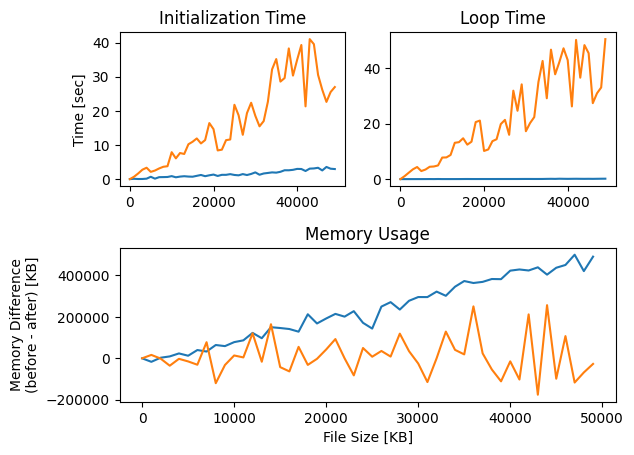

In [45]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5, hspace=0.4)

ax1 = plt.subplot(gs[0, :2])
ax1.set_title("Initialization Time")
ax1.set(ylabel="Time [sec]")
ax1.plot(standard_file_sizes, standard_init_time)
ax1.plot(stream_file_sizes, stream_init_time)

ax2 = plt.subplot(gs[0, 2:])
ax2.set_title("Loop Time")
ax2.plot(standard_file_sizes, standard_loop_time)
ax2.plot(stream_file_sizes, stream_loop_time)

ax3 = plt.subplot(gs[1, :])
ax3.set_title("Memory Usage")
ax3.set(xlabel="File Size [KB]")
ax3.set(ylabel="Memory Difference\n(after - before) [KB]")
ax3.plot(standard_file_sizes, standard_mem_usage)
ax3.plot(stream_file_sizes, stream_mem_usage)

plt.show()